# Телеком

# Создание плана проекта "Телеком" - предсказание оттока клиентов

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

In [8]:
#!pip install phik
#pip install ipywidgets
#pip install -U scikit-learn
#pip install ipywidgets
#pip install imbalanced-learn

In [9]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import warnings
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from phik.report import plot_correlation_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import (
                                    GridSearchCV,
                                    train_test_split
                                    )
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,  roc_auc_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import catboost
from catboost import Pool, cv
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics
from sklearn.inspection import permutation_importance

In [10]:
warnings.filterwarnings('ignore')
sns.set()
sns.set_style("whitegrid")

In [11]:
try:
    df_contract = pd.read_csv('contract_new.csv',parse_dates=['BeginDate'],index_col='customerID')
    df_internet = pd.read_csv('internet_new.csv',index_col='customerID')
    df_personal = pd.read_csv('personal_new.csv',index_col='customerID')
    df_phone    = pd.read_csv('phone_new.csv',index_col='customerID')
except:
    df_contract = pd.read_csv('/datasets/contract_new.csv',parse_dates=['BeginDate'],index_col='customerID')
    df_internet = pd.read_csv('/datasets/internet_new.csv',index_col='customerID')
    df_personal = pd.read_csv('/datasets/personal_new.csv',index_col='customerID')
    df_phone    = pd.read_csv('/datasets/phone_new.csv',index_col='customerID')

In [12]:
df = {'contract': df_contract,
      'internet':df_internet,
      'person':df_personal,
      'phone':df_phone}
for d in df.values():
    d.columns = d.columns.str.lower()

Первая таблица содержит данные **контракта**

### Contract

- CustomerId - ID клиента
- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – безналичный расчет,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги,
- TotalCharges – всего потрачено денег на услуги

In [14]:
df['contract'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7043 non-null   datetime64[ns]
 1   enddate           7043 non-null   object        
 2   type              7043 non-null   object        
 3   paperlessbilling  7043 non-null   object        
 4   paymentmethod     7043 non-null   object        
 5   monthlycharges    7043 non-null   float64       
 6   totalcharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 440.2+ KB


In [15]:
df['contract'].duplicated().sum()

37

Видно, что **totalcharges** является строкой, а не числом 

In [16]:
df['contract'].describe()

,begindate,monthlycharges
count,7043,7043.000000
mean,2017-04-30 13:01:50.918642688,64.761692
min,2013-10-01 00:00:00,18.250000
25%,2015-06-01 00:00:00,35.500000
50%,2017-09-01 00:00:00,70.350000
75%,2019-04-01 00:00:00,89.850000
max,2020-02-01 00:00:00,118.750000
std,NaN,30.090047


### Internet

In [18]:
df['internet'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   internetservice   5517 non-null   object
 1   onlinesecurity    5517 non-null   object
 2   onlinebackup      5517 non-null   object
 3   deviceprotection  5517 non-null   object
 4   techsupport       5517 non-null   object
 5   streamingtv       5517 non-null   object
 6   streamingmovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [19]:
df['internet'].duplicated().sum()

5389

### Person

- Dependents – наличие иждивенцев
- Senior Citizen – наличие пенсионного статуса по возрасту
- Partner – наличие супруга(и)

In [21]:
df['person'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   seniorcitizen  7043 non-null   int64 
 2   partner        7043 non-null   object
 3   dependents     7043 non-null   object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


In [22]:
df['person'].duplicated().sum()

7027

### Phone

- MultipleLines – наличие возможности ведения параллельных линий во время
звонка

In [24]:
df['phone'].info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   multiplelines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [25]:
df['phone'].duplicated().sum()

6359

### Вывод

**Не смотря на то, что данные заполнены без пропусков и явных дубликатов, в них содержится ошибки в заполении с типом. Также видно, что количество контрактов превышает количество значений в таблицах phone и internet, что может указывать на пропуски и что клиент пользователь только одной услуги.  Также стоит проверить наличие неявных дубликатов, посмотреть уникальные значения и распределение**

## План проекта

1. Исследование и первичная обработка данных:
- Изучить все поля: убрать дубликаты, изучить уникальные значения, отфильтровать аномалии и прочее
- Построить необходимые графики
- Сделать выводы
2. Обработка и подготовка данных
- Закодировать переменные
- Построить матрицу корреляции
- Отобрать признаки
- Разбить выборки для обучения и тестирования
3. Выбор и обучение модели
- Рассмотреть наиболее подходящие метрики и функции потерь для обучения
- Обучить линейную регрессию, чтобы оценить важность признаков (может убрать часть из них)
- Обучить интерпретируемую модель - дерево решений, но скорее случайный лес
- Выбрать и обучить градиентный бустинг
- Отобрать лучшую модель по итогам валидации
4. Проверка модели 
- Протестировать модель
- Построить графики ROC-AUC, посчитать метрики
- Сделать итоговый вывод

# Подготовка данных

В силу того, что таблицы содержат не большое количество полей, соедним их всех в одну таблицу. Таблица с контрактами является главной, поэтому объединим по индексам таблицы contract. Но для начала подготовим кажду таблицу по отдельности

## Contract

Так как многие признаки категориальные рассмотрим уникальные значения таких понелей

In [27]:
for i in df_contract.columns:
    if df_contract[i].dtype == 'O':
        print(i,'\n',df_contract[i].unique())

enddate 
 ['No' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01' '2018-12-01'
 '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01' '2016-07-01'
 '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01' '2019-06-01'
 '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01' '2016-12-01'
 '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01' '2018-04-01'
 '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01' '2014-06-01'
 '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01' '2018-05-01'
 '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01' '2016-10-01'
 '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01' '2015-07-01'
 '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01' '2016-11-01'
 '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01' '2016-08-01'
 '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01' '2017-01-01'
 '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01' '2014-12-01'
 '2014-11-01']
type 
 ['Month-to-month' 'One year' 'Two year']
paperlessbilling 
 ['Yes' 'No']
paymentmethod 
 ['Electronic che

Мы видем две особенности таблицы, не смотря на то что поля **enddate** и **totalcharges** должны быть типа дата и число, они тоже являются строковыми переменными. Если **enddate** имеет No, что говорит о том что клиент еще пользуется. А вот с **totalcharges** непонятно. Изучим более подробно

In [28]:
list_to_remove = []
for i in range(df_contract['totalcharges'].shape[0]):
    try:
        float(df_contract['totalcharges'][i])
    except:
        display(df_contract.iloc[i].to_frame())
        print('value =',df_contract['totalcharges'][i])
        list_to_remove.append(i)

,4472-LVYGI
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,Yes
paymentmethod,Bank transfer (automatic)
monthlycharges,52.55
totalcharges,


value =  


,3115-CZMZD
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,20.25
totalcharges,


value =  


,5709-LVOEQ
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,80.85
totalcharges,


value =  


,4367-NUYAO
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,25.75
totalcharges,


value =  


,1371-DWPAZ
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Credit card (automatic)
monthlycharges,56.05
totalcharges,


value =  


,7644-OMVMY
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,19.85
totalcharges,


value =  


,3213-VVOLG
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,25.35
totalcharges,


value =  


,2520-SGTTA
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,20.0
totalcharges,


value =  


,2923-ARZLG
begindate,2020-02-01 00:00:00
enddate,No
type,One year
paperlessbilling,Yes
paymentmethod,Mailed check
monthlycharges,19.7
totalcharges,


value =  


,4075-WKNIU
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,No
paymentmethod,Mailed check
monthlycharges,73.35
totalcharges,


value =  


,2775-SEFEE
begindate,2020-02-01 00:00:00
enddate,No
type,Two year
paperlessbilling,Yes
paymentmethod,Bank transfer (automatic)
monthlycharges,61.9
totalcharges,


value =  


**Вывод:** мы видим, что 11 клиентов не внесли платеж, вместо него пробел, потому что только начали использовать услугу. Смело удалим таких клиентов, они не внесут никакой полезной информации

In [29]:
df_contract = df_contract[df_contract['totalcharges'] != ' ']
df_contract['totalcharges'] = df_contract['totalcharges'].astype(float)

Переведем **enddate** в дату, No заменим на последнюю дату, а также сделаем целевой признак пользуется ли клиент услугой или нет 

In [31]:
df_contract['user'] = int(0) 
df_contract['user'][df_contract['enddate'] != 'No'] = int(1)
df_contract['enddate'][df_contract['enddate'] == 'No'] = '2020-02-01'
df_contract['enddate'] = pd.to_datetime(df_contract['enddate'], format="%Y-%m-%d")
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   begindate         7032 non-null   datetime64[ns]
 1   enddate           7032 non-null   datetime64[ns]
 2   type              7032 non-null   object        
 3   paperlessbilling  7032 non-null   object        
 4   paymentmethod     7032 non-null   object        
 5   monthlycharges    7032 non-null   float64       
 6   totalcharges      7032 non-null   float64       
 7   user              7032 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 494.4+ KB


Теперь найдем срок использования

In [32]:
df_contract['using_time'] =  (df_contract['enddate'] - df_contract['begindate']).dt.days
df_contract = df_contract.drop(['enddate','begindate'],axis=1)

In [33]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7032 non-null   object 
 1   paperlessbilling  7032 non-null   object 
 2   paymentmethod     7032 non-null   object 
 3   monthlycharges    7032 non-null   float64
 4   totalcharges      7032 non-null   float64
 5   user              7032 non-null   int64  
 6   using_time        7032 non-null   int64  
dtypes: float64(2), int64(2), object(3)
memory usage: 439.5+ KB


Рассмотрим каждое поле более подробно

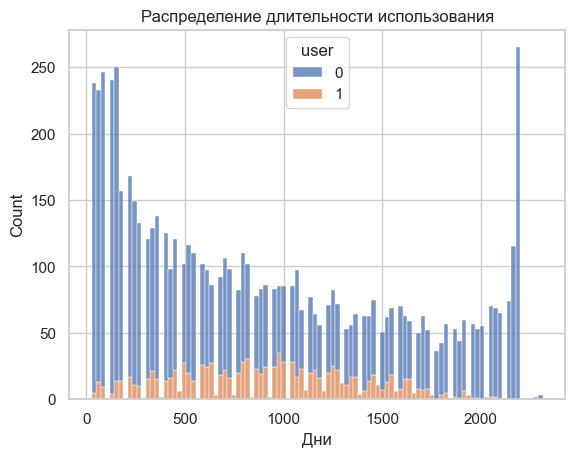

In [34]:
sns.histplot(df_contract, x='using_time', hue='user',bins=100, multiple="stack")
plt.title('Распределение длительности использования')
plt.xlabel('Дни')
plt.show()

In [ ]:
plt.figure(figsize=(3,2))
df_contract['user'].hist()
plt.title('Доля действующих клиентов')
plt.show()
round(df_contract['user'].value_counts() / len(df_contract['user']),2)

In [ ]:
plt.figure(figsize=(7,3))
sns.histplot(df_contract, x='totalcharges', hue='user',bins=100, multiple="stack")
plt.title('Распределение суммарной траты')
plt.xlabel('Доллары')
plt.show()

In [ ]:
plt.figure(figsize=(7,3))
sns.histplot(df_contract, x='monthlycharges', hue='user',bins=100, multiple="stack")
plt.title('Распределение месячных трат')
plt.xlabel('Доллары')
plt.show()

In [ ]:
fig, ax = plt.subplots(1,3, figsize = (10,3),)
ax = ax.flatten()
for i,j in zip(df_contract.columns[:3],ax):
    df_contract[i].hist(ax=j,xrot=30)
    j.set_title(i)

**Вывод по таблице Contract:**

Были подготовленны данные, начало и конец использования было замененно полем с длительностью использования, добавлен целевой признак, данные были приведены к надлежащему типу. Пропуски и дубликаты не обнарженны. 

- Распределение времени использования услуг показывает, что количество клиентов увеличивается у компании. Есть пик около 2000 дней, это группа лояльных клиентов с основания компании. Распределение по группам указывает, что если клиент использует услуги компании более 700-800 дней, он становится лояльным и не уходит, на что указывает плато. Распределение ушедших клиентов колокообразное с пиком около 1000 дней. Отличительной особенностью является наличие большого количества пиков. Так как большое количество 
- Распределение ушедших к действующим клиентам примерно 1/5. (16% и 84% соответственно)
- Месячные траты состоят примерно из 18 пиков, скорее всего столько тарифов +- варьирование допуслугами
- Более половины контрактов помесячные 
- Около 40% платят наличкой. Бедные, бедные, бедолаги...


## Internet

In [ ]:
df_internet.head()

In [ ]:
for i in df_internet.columns:
    display(df_internet[i].value_counts())

**Вывод по Internet:** В данных нет пропусков и дубликатов

## Person и Phone

In [ ]:
df_personal.head()

In [ ]:
for i in df_personal.columns:
    display(df_personal[i].value_counts())

In [ ]:
df_phone.value_counts()

**Вывод:** данные подготовлены, можно объединять 

Левое объединение по индексам, главная таблица - contract

In [35]:
df_all = df_contract.join(pd.concat([df_internet, df_personal,df_phone],axis=1),how='left')
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              7032 non-null   object 
 1   paperlessbilling  7032 non-null   object 
 2   paymentmethod     7032 non-null   object 
 3   monthlycharges    7032 non-null   float64
 4   totalcharges      7032 non-null   float64
 5   user              7032 non-null   int64  
 6   using_time        7032 non-null   int64  
 7   internetservice   5512 non-null   object 
 8   onlinesecurity    5512 non-null   object 
 9   onlinebackup      5512 non-null   object 
 10  deviceprotection  5512 non-null   object 
 11  techsupport       5512 non-null   object 
 12  streamingtv       5512 non-null   object 
 13  streamingmovies   5512 non-null   object 
 14  gender            7032 non-null   object 
 15  seniorcitizen     7032 non-null   int64  
 16  partner           7032 non-null 

Видно, что объединение таблиц привело к наличию пропусков в категориальных признаках, так как услугами в этих полях не пользовались. Заменим пропуски на "No"

In [36]:
df_all.fillna('No',inplace=True)

Данные подготовлены для разделения выборок, кодировки и масштабирования. Тестовая выборка будет содержать 25% генеральной совокупности  

interval columns not set, guessing: ['monthlycharges', 'totalcharges', 'user', 'using_time', 'seniorcitizen']


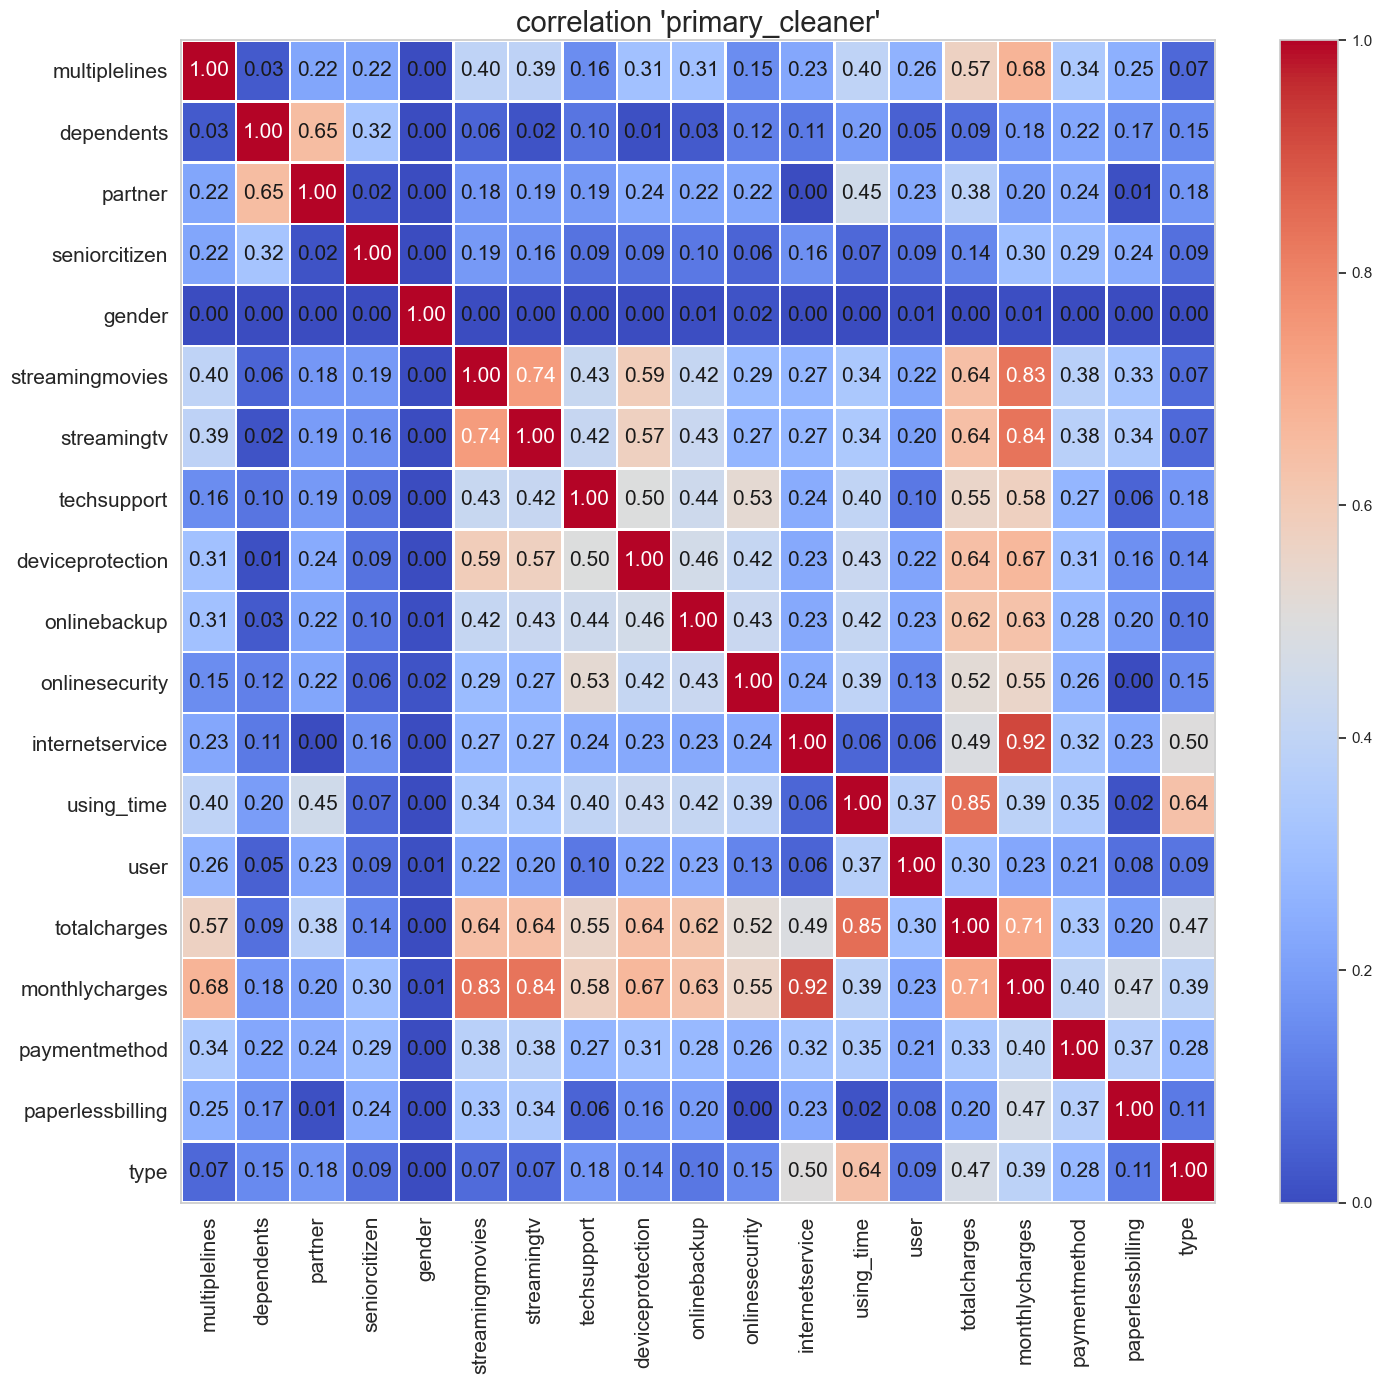

In [37]:
phik_overview = df_all.phik_matrix()
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, 
                        color_map='coolwarm',
                        title=r"correlation 'primary_cleaner'", 
                        fontsize_factor=1.5, 
                        figsize=(15, 14))

Отберем признаки, которые не коррелируют с целевым **user**: dependents, gender, seniorcitizen, internetservice, type, paperlessbilling. Удалим эти столбцы. Помимо этого у нас есть есть другие коррелирующие признаки, **monthlycharges** коррелирует с многими призаками, поэтому удалим его. Также удалим суммарный платеж **totalcharges**, логично что он сильно связан с временем использованием и есть ли платеж по дополнительным услугам. В данных есть дисбаланс, следовательно, не забудем **stratify=target**.

In [38]:
RANDOM_STATE = 80523
feature = df_all.drop(['user','type', 'paperlessbilling',
                       'internetservice','seniorcitizen',
                       'gender','dependents',
                       'totalcharges','monthlycharges'],axis=1)
target = df_all['user'] 
x_train, x_test, y_train, y_test = train_test_split(feature, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target)

In [ ]:
x_train.shape

In [ ]:
x_test.shape

Закодируем и отмасштабируем данные. Для кодировки будем использовать **OneHotEncoder**. Для маштабирования будем использовать **RobustScaler**, так как данные не распределены нормально и имеют выбросы и явные пики, нам важно их сохранить. 

In [39]:
#составим списки с числовыми и символьными признаками
columns_o = x_train.select_dtypes(include='object').columns.to_list()
columns_n = x_train.select_dtypes(exclude='object').columns.to_list()

scale = RobustScaler()
scale.fit(x_train[columns_n])
x_train[columns_n] = scale.transform(x_train[columns_n])
x_test[columns_n] = scale.transform(x_test[columns_n])

#енкодер для символьных столбцов
oe = make_column_transformer(
        (OneHotEncoder(), columns_o),
         remainder='drop',)
x_train_oe = oe.fit_transform(x_train)
x_test_oe = oe.transform(x_test)

**Итоговый вывод:** в ходе подготовки и анализа данных были подготовлены признаки: 

Таблицы спарсены, пропуски заменены, данные разделены с учетом дисбаланса,  проведена кодировка и масштабирование

# Выбор и обучение модели

Для начала построим линейную модель

In [213]:
model_lr = LogisticRegression(random_state=RANDOM_STATE)

col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        columns_o
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

x_train_lr = pd.DataFrame(
    col_transformer.fit_transform(x_train),
    columns=col_transformer.get_feature_names_out()
)

cv_lr = cross_val_score(model_lr,
                        x_train_oe,
                        y_train,
                        scoring='roc_auc',)
print("Mean score: ", round(cv_lr.mean(),2))

Mean score:  0.71


Обучим модель **случайного леса**. Согласна рекомендациям при обучении леса лучше не дропать первое значение в параметрах при кодировки onehotencoder.

In [214]:
%%time
model_forest = RandomForestClassifier(class_weight={0: 7, 1: 1}, random_state=RANDOM_STATE)
col_transformer = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore'),
        columns_o
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)
pipeline_forest = make_pipeline(col_transformer, model_forest)
parameters = {'randomforestclassifier__n_estimators': range(100, 300, 20),
              'randomforestclassifier__max_depth': range(4, 12),
             }
gs_ridge_forest = GridSearchCV(
    pipeline_forest, 
    param_grid=parameters, 
    scoring='roc_auc', 
    n_jobs=-1)
gs_ridge_forest.fit(x_train, y_train)

CPU times: total: 6.42 s
Wall time: 1min 30s


GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['paymentmethod',
                                                                          'onlinesecurity',
                                                                          'onlinebackup',
                                                                          'deviceprotection',
                                                                          'techsupport',
                                                                          'streamingtv',
                                                                          'streamingmovies',
                                                                          'partner',
                                                                          'multiplelines'])],
                                                          verbose_feature_names_out=False)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(class_weight={0: 7,
                                                                             1: 1},
                                                               random_state=80523))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(4, 12),
                         'randomforestclassifier__n_estimators': range(100, 300, 20)},
             scoring='roc_auc')

In [215]:
gs_rf_best_score = gs_ridge_forest.best_score_ 
gs_rf_best_params = gs_ridge_forest.best_params_
print(f'best_roc_auc: {round(gs_rf_best_score,3)}')
print(f'best_params: {gs_rf_best_params}')

best_roc_auc: 0.794
best_params: {'randomforestclassifier__max_depth': 6, 'randomforestclassifier__n_estimators': 160}


Лучшие результаты выдал лес при количестве 160 деревьев и глубине 6 с результатом 0,8

In [216]:
cat_features = x_train.columns.get_indexer(columns_o)
pool = Pool(data=x_train.values, label=y_train.values,cat_features=cat_features)

In [217]:
params = {
    'loss_function': 'Logloss',
    'iterations': 180,
    'eval_metric': 'AUC',
    'random_seed': RANDOM_STATE,
    'learning_rate': 0.5,
    'early_stopping_rounds':10,
    
}

cv_data = cv(
    params=params,
    pool=pool,
    fold_count=5, 
    shuffle=True, 
    partition_random_seed=RANDOM_STATE,
    stratified=True, 
    verbose_eval=False,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.9314132936
bestIteration = 59

Training on fold [1/5]

bestTest = 0.9171024855
bestIteration = 65

Training on fold [2/5]

bestTest = 0.9401804562
bestIteration = 55

Training on fold [3/5]

bestTest = 0.9144629649
bestIteration = 79

Training on fold [4/5]

bestTest = 0.9225210485
bestIteration = 65



In [ ]:
cv_data.sort_values(by='test-AUC-mean',ascending=False).head(5)

**Вывод по выбору моделей:** классификатор CatBoost показал значительный прирост в показатели AUC - 0,916 на валидации по сравнению со случайным лесом - 0,8 и линейной регрессией - 0,7. Различное варьирование параметров показало, что борьба с дисбалансом по средствам изменения весов только ухудшала показатель модели, модель достигла максимума при 0,80-85 итераций

# Проверка модели

На предыдущем этапе мы нашли лучшую модель - градиентный бустинг. Проведем тест модели и построим кривую ROC-AUC 

In [219]:
cbc = CatBoostClassifier(iterations=150,
                         eval_metric='AUC',
                         random_seed=RANDOM_STATE,
                         learning_rate=0.5,
                         early_stopping_rounds=10,
                         )
cbc.fit(x_train.values, y_train.values,
        cat_features=cat_features,
        eval_set=(x_test.values, y_test.values),
        verbose=False,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [220]:
eval_pool = Pool(x_test.values, y_test.values, cat_features=cat_features)
curve = get_roc_curve(cbc, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

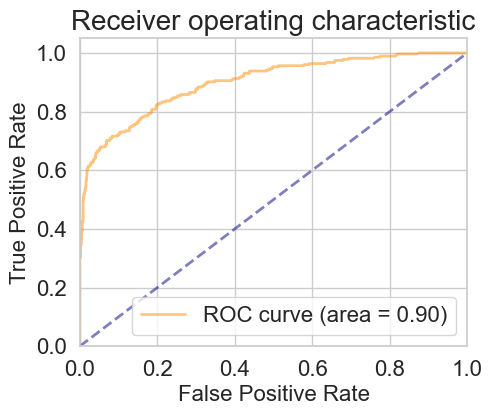

In [235]:
plt.figure(figsize=(5, 4))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

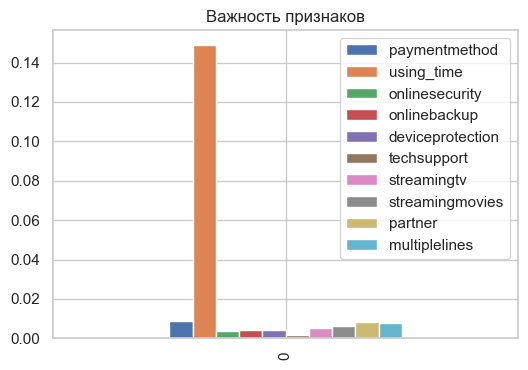

In [243]:
model_fi = permutation_importance(cbc, x_train.values,y_train.values)
fi = pd.DataFrame([model_fi['importances_mean']],columns=x_train.columns)
fi.plot(kind='bar',figsize=(6,4))
plt.title('Важность признаков')
plt.show()

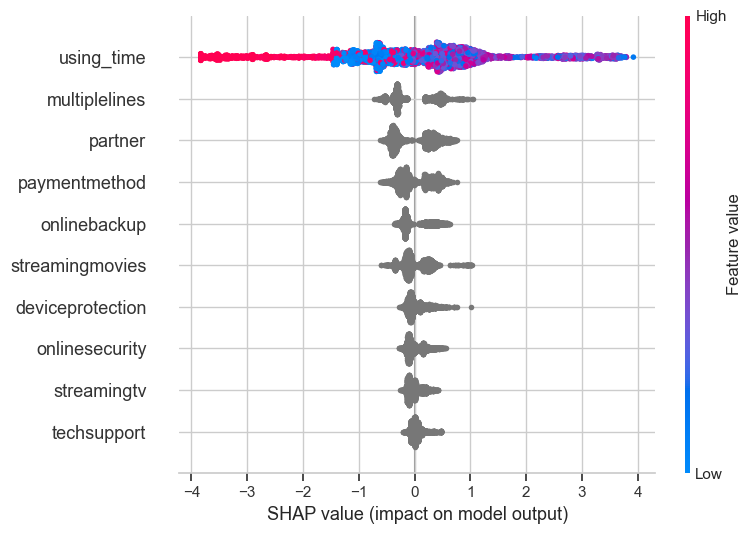

In [234]:
shap_test = shap.TreeExplainer(cbc).shap_values(x_train.values)
shap.summary_plot(shap_test, x_train,
                      max_display=25, auto_size_plot=True)

**Вывод:** Модель градиентного бустинга покащала хороший результат 0,92 на тренировочной выборке, такой же результат на валидационной выборке, что может указывать на то, что модель не переобучилась. Наиболее важный признак - время использования услугами, что является очевидным.

**Итоговый вывод:**

- В первом части были изучены и подготовлены данные, проведено исследование признаков и их первичная обработка
- Во втрой части была осуществленна подготовка признаков, создание целевого признака. После проверки корреляции были убраны взаимосвязанные признаки, выборка была разделена на обучающую и тестовую
- В третьей части были обученные три модели: логистическая регрессия (0,7), случайный лес (0,8) и градиентный бустинг (0,92). Градиентный бустинг показал наилучший вариант
- В последней части был проведен тест модели CatBoost, он показал необходимую точность. Также продемонстрированно, что время использование является наиболее важным признаком, причем подовляющее важный.

# Отчет

Выполнение проекта состояло из трех этапов и следовала намеченному плану.

**Первым этапом стало превичная обработка данных.** В ходе знакомства с данными были обнаруженны две ошибки в записях, поля с датами имели формат строки, также поле с платежом вместо числового имело тип объекта, так как пропуски заполнены пробелом, а не Nan (таких клиентов только 11, они были удалены). Далее все таблицы были объединены в одну, добавлен целевой признак, поля с датами заменены на поле с длительностью использования. 

Построены все необходимые графики. Обнаружен дисбаланс - ушедших пользователей меньше в 5 раз. С помощью библиотеки phik построена матрица корреляций, исходя из показателей матрицы были отброшены сильно взаимосвязанные признаки, чтобы избежать мультиколлинеарности. 

Генеральная совокупность была разделена на тренировочную и тестовую в пропорции 1/4. Признаки для обучения молели: 'paymentmethod', 'using_time', 'onlinesecurity', 'onlinebackup','deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies','partner', 'multiplelines'. random_state взят равным 80523, дата начала проекта.

**На втором этапе** были выбраны три модели и проверены на кросс валидации, линейная модель показала результат 0,72, случайный лес показал 0,8, лучишм стал бустинг с 0,92. В ходе варьирования параметров лучший результат выдал CatBoostClassifier c iterations=150, learning_rate=0.5.

Проверка модели показала хороший результат с 0,9 roc-auc, была построена кривая, а также проведен анализ важности признаков. Наиболее важным признаком является время использование, что очень логично.
